In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras
import pandas as pd
import seaborn as sb
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
import math



taxi_epochs = 1
wind_epochs = 1

metric = 'mae'

patience = 10

# Time Series Forecasting with LSTM Networks

### Utility functions

In [2]:
class ResetStatesCallback(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
reset_states = ResetStatesCallback()
early_stoppage = keras.callbacks.EarlyStopping(patience=patience)

In [3]:
def plot_series_by_date(series, start_date = '2014-07-01 00:30:00', end_date = '2015-01-31 23:30:00'):
  fig = plt.figure(figsize=(15,5))
  start_index = df[df['timestamp'] == pd.to_datetime(start_date, infer_datetime_format=True)].index.to_list()[0]
  end_index = df[df['timestamp'] == pd.to_datetime(end_date, infer_datetime_format=True)].index.to_list()[0]
  print(start_index)
  plt.plot(series['timestamp'][start_index:end_index],series['value'][start_index:end_index])
  plt.xlabel('Date')
  plt.ylabel('Traffic Volume')

In [4]:
def plot_series(time, series, format="-", title = '',start=0, end=None, label=None, xlabel=None, ylabel=None):
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.title(title)
    if xlabel is None:
      xlabel="Timesteps"
    if ylabel is None:
      ylabel='Value'
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

In [5]:
#create benchmark dataset
def create_benchmark_forecast(sequence, n_steps_in, n_steps_out):
  X,y = list(), list()

  for pattern_start in range(0, len(sequence)):
    # finde the end of this pattern:
    pattern_end = pattern_start + n_steps_in
    prediction_end = pattern_end + n_steps_out
    #check if we are beyond the dataset:
    if prediction_end > len(sequence):
      break
    #gather input and output parts of the pattern
    if len(sequence.shape) == 1:
      seq_y = np.full(shape=n_steps_out, fill_value = sequence[pattern_end-1])
    else:
      seq_y = np.full(shape=n_steps_out, fill_value = sequence[pattern_end-1, -1])
    y.append(seq_y)
  return array(y)

In [6]:
#create windowed dataset
def create_windowed_datasets(sequences, n_steps_in, n_steps_out, sequence_to_sequence_RNN = False, is_stateful_network=False):
  X,y = list(), list()
  stride = 1
  if is_stateful_network:
      stride = n_steps_in
  for pattern_start in range(0, len(sequences), stride):
    # finde the end of this pattern:
    pattern_end = pattern_start + n_steps_in
    if sequence_to_sequence_RNN:
      prediction_start = pattern_start+1
    else:
      prediction_start = pattern_end
    prediction_end = pattern_end + n_steps_out
    #check if we are beyond the dataset:
    if prediction_end > len(sequences):
      break
    #gather input and output parts of the pattern
    if len(sequences.shape) == 1:
      seq_x, seq_y = sequences[pattern_start:pattern_end], sequences[prediction_start: prediction_end]
    else:
      seq_x, seq_y = sequences[pattern_start:pattern_end, :], sequences[prediction_start:(prediction_end), -1]
    X.append(seq_x)
    y.append(seq_y)
  return array(X), array(y)


In [7]:
def split_series(series : np.ndarray, train_percentage = 0.8, valid_percentage = 0.1, test_percentage = 0.1):
  length = series.shape[0]
  test = train_percentage * length
  train_split = math.ceil(train_percentage * length)
  valid_split = math.ceil((train_percentage + valid_percentage) * length)
  train_series = series[:train_split]
  valid_series = series[train_split:valid_split]
  test_series = series[valid_split:]
  return train_series, valid_series, test_series, train_split, valid_split

#### Utility tests

In [8]:
#Test data univariate
sequence = array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
print('Univariate Testdata: ', sequence)
#Test data multivariate
# multivariate data preparation
from numpy import array
from numpy import hstack
# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95, 105])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
print('Multivariate Testdata: ', dataset)

Univariate Testdata:  [ 10  20  30  40  50  60  70  80  90 100]
Multivariate Testdata:  [[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]
 [ 90  95 185]
 [100 105 205]]


In [9]:
#Test split series
train, valid, test, train_split, valid_split = split_series(sequence) 
assert np.array_equal(train, [10, 20, 30, 40, 50, 60, 70, 80])
assert np.array_equal(valid, [90])
assert np.array_equal(test, [100])
assert train_split == 8
assert valid_split == 9

In [10]:
#Test create_benchmark_dataset

In [11]:
result = create_benchmark_forecast(sequence=sequence, n_steps_in=4, n_steps_out=2)
expected = np.asarray([[40,40],[50, 50],[60, 60],[70, 70],[80, 80]], dtype=float)
assert np.array_equal(result, expected)
assert result.shape == (5,2)

In [12]:
result = create_benchmark_forecast(sequence=dataset, n_steps_in=4, n_steps_out=3)
assert result.shape == (4,3)

In [13]:
#Test create_windowed_dataset

In [14]:
X, Y = create_windowed_datasets(sequence, 3, 1, True, True)
assert X.shape == (3,3)
assert Y.shape == (3,3)
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [10 20 30]
Y0:  [20 30 40]
X1:  [40 50 60]
Y1:  [50 60 70]
X2:  [70 80 90]
Y2:  [ 80  90 100]


In [15]:
X, Y = create_windowed_datasets(sequence, 5, 2, True)
assert X.shape == (4,5)
assert Y.shape == (4,6)
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [10 20 30 40 50]
Y0:  [20 30 40 50 60 70]
X1:  [20 30 40 50 60]
Y1:  [30 40 50 60 70 80]
X2:  [30 40 50 60 70]
Y2:  [40 50 60 70 80 90]
X3:  [40 50 60 70 80]
Y3:  [ 50  60  70  80  90 100]


In [16]:
X, Y = create_windowed_datasets(sequence, 5, 2)
assert X.shape == (4,5)
assert Y.shape == (4,2)
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [10 20 30 40 50]
Y0:  [60 70]
X1:  [20 30 40 50 60]
Y1:  [70 80]
X2:  [30 40 50 60 70]
Y2:  [80 90]
X3:  [40 50 60 70 80]
Y3:  [ 90 100]


In [17]:
X, Y = create_windowed_datasets(sequence, 5, 1)
assert X.shape == (5,5)
assert Y.shape == (5,1)
X, Y = create_windowed_datasets(sequence, 1, 5)
assert X.shape == (5,1)
assert Y.shape == (5,5)
X, Y = create_windowed_datasets(sequence, 9, 1)
assert X.shape == (1,9)
assert Y.shape == (1,1)
X, Y = create_windowed_datasets(sequence, 1, 9)
assert X.shape == (1,1)
assert Y.shape == (1,9)

In [18]:
X, Y = create_windowed_datasets(dataset, 5, 2)
assert X.shape == (4,5,3)
assert Y.shape == (4,2)

In [19]:
for i in range(len(Y)):
  print('X{}: '.format(i), X[i])
  print('Y{}: '.format(i), Y[i])

X0:  [[ 10  15  25]
 [ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]]
Y0:  [125 145]
X1:  [[ 20  25  45]
 [ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]]
Y1:  [145 165]
X2:  [[ 30  35  65]
 [ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]]
Y2:  [165 185]
X3:  [[ 40  45  85]
 [ 50  55 105]
 [ 60  65 125]
 [ 70  75 145]
 [ 80  85 165]]
Y3:  [185 205]


In [20]:
X, Y = create_windowed_datasets(dataset, 4, 3)
assert X.shape == (4,4,3)
assert Y.shape == (4,3)
X, Y = create_windowed_datasets(dataset, 1, 8)
assert X.shape == (2,1,3)
assert Y.shape == (2,8)
X, Y = create_windowed_datasets(dataset, 2, 8)
assert X.shape == (1,2,3)
assert Y.shape == (1,8)
X, Y = create_windowed_datasets(dataset, 8, 2)
assert X.shape == (1,8,3)
assert Y.shape == (1,2)

## Univariate Time Series

In [21]:
df = pd.read_csv('taxi.csv')
df['timestamp']=pd.to_datetime(df['timestamp'], infer_datetime_format=True)
timestamp = df['timestamp'].to_numpy()
series = df['value'].to_numpy()


In [22]:
def plot_series_by_date(series, start_date = '2014-07-01 00:30:00', end_date = '2015-01-31 23:30:00'):
  fig = plt.figure(figsize=(15,5))
  start_index = df[df['timestamp'] == pd.to_datetime(start_date, infer_datetime_format=True)].index.to_list()[0]
  end_index = df[df['timestamp'] == pd.to_datetime(end_date, infer_datetime_format=True)].index.to_list()[0]
  print(start_index)
  plt.plot(series['timestamp'][start_index:end_index],series['value'][start_index:end_index])
  plt.xlabel('Date')
  plt.ylabel('Traffic Volume')

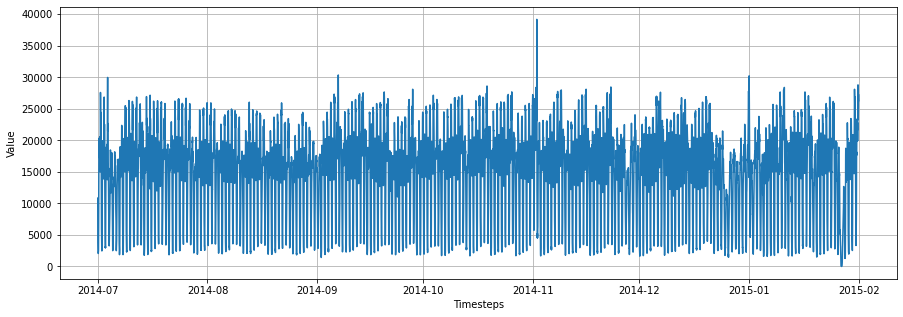

In [23]:
fig = plt.figure(figsize=(15,5))
plot_series(timestamp, series)

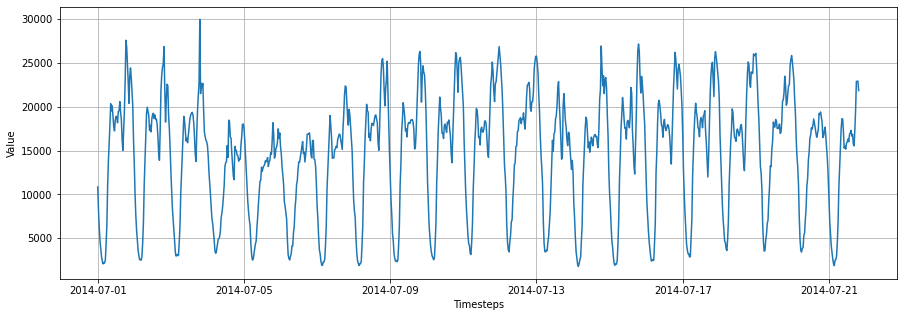

In [24]:
fig = plt.figure(figsize=(15,5))
plot_series(timestamp[0:1000], series[0:1000])
plt.savefig('some_name.eps', bbox_inches='tight')

1


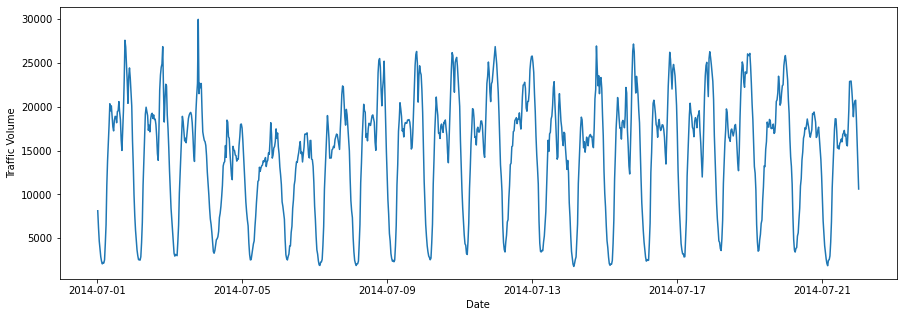

In [25]:
plot_series_by_date(df, '2014-07-01 00:30:00', '2014-07-22 00:30:00')

#### Preprocessing data

In [26]:
#Normalize data, so that all values are between 0 and 1
maximum = series.max()
f = lambda x: x/maximum
series = f(series)
time = df.index.to_numpy()

In [27]:
#Split in train, validate and test data
train_series, valid_series, test_series, train_split, valid_split = split_series(series, 0.8, 0.1, 0.1)

### Single Step Forecasting using stateful, stacked LSTM and sequence to sequence learinng

In [28]:
def sequential_window_dataset(series, window_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=window_size, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(window_size + 1))
    ds = ds.map(lambda window: (window[:-1], window[1:]))
    return ds.batch(1).prefetch(1)

In [29]:
keras.backend.clear_session()
window_size = 30
train_set = sequential_window_dataset(train_series, window_size)
val_set = sequential_window_dataset(valid_series, window_size)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [30]:
test = train_set.as_numpy_iterator()
for i in range(1):
  elem = test.next()
  print('X', elem[0].shape)
  print('Y', elem[1].shape)

X (1, 30, 1)
Y (1, 30, 1)


In [31]:
n_steps_in = 30
n_steps_out = 1

X_train, y_train = create_windowed_datasets(valid_series, n_steps_in, n_steps_out, is_stateful_network = True, sequence_to_sequence_RNN= True)
X_valid, y_valid = create_windowed_datasets(train_series, n_steps_in, n_steps_out, is_stateful_network = True, sequence_to_sequence_RNN= True)

In [32]:
X_train.shape

(34, 30)

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential([
  keras.layers.LSTM(100, return_sequences=True, stateful=True,
                    batch_input_shape=[1, None, 1]),
  keras.layers.LSTM(100, return_sequences=True, stateful=True),
  keras.layers.Dense(1),
  keras.layers.Lambda(lambda x: x * 200.0)
])


optimizer = keras.optimizers.SGD(learning_rate=1e-10, momentum=0.9)
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=[metric])

In [34]:
model_checkpoint = keras.callbacks.ModelCheckpoint('singlevariate_singlestep_stateful.h5', save_best_only=True)

history = model.fit(train_set, 
                    epochs=taxi_epochs,
                    callbacks=[reset_states, model_checkpoint, early_stoppage],
                    validation_data=val_set)

275/275 [==============================] - 27s 62ms/step - loss: 0.4105 - mae: 0.5409 - val_loss: 0.0053 - val_mae: 0.0871


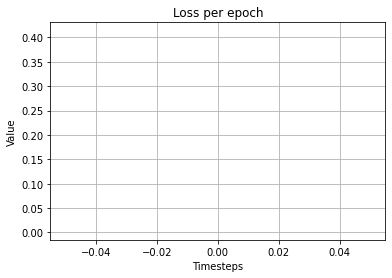

In [35]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_series(range(len(loss)), loss, title='Loss per epoch', xlabel='epoch', ylabel='loss')
plot_series(range(len(val_loss)), val_loss, title='Loss per epoch')

In [36]:
model = keras.models.load_model("singlevariate_singlestep_stateful.h5")

In [37]:
rnn_forecast = model.predict(series[np.newaxis, :, np.newaxis])
rnn_forecast = rnn_forecast[0, valid_split - 1:-1, 0]

1/1 [==============================] - 5s 5s/step


In [38]:
rnn_forecast.shape

(1032,)

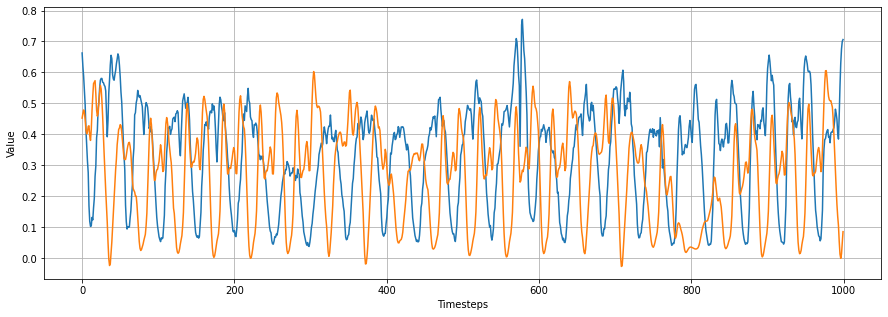

In [39]:
plt.figure(figsize=(15, 5))
end = 1000
plot_series(range(len(valid_series[0:end])),valid_series[0:end], format='-')
plot_series(range(len(valid_series[0:end])), rnn_forecast[0:end], format='-', )

In [40]:
keras.metrics.mean_absolute_error(valid_series, rnn_forecast).numpy()

0.22169209

### Single Step Forecasting using stacked LSTM

#### Data Preparation

In [41]:
len(series) -1002 -1002-8226

90

In [42]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 30, 1
n_features = 1
if len(valid_series.shape) > 1:
  n_features = valid_series.shape[1]
# split into samples
X_train, y_train  = create_windowed_datasets(train_series, n_steps_in, n_steps_out)
X_valid, y_valid  = create_windowed_datasets(valid_series, n_steps_in, n_steps_out)
X_test, y_test    = create_windowed_datasets(test_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)
print('X_valid: ', X_test.shape)
print('y_valid: ', y_test.shape)

X_train:  (8226, 30)
y_train:  (8226, 1)
X_valid:  (1002, 30)
y_valid:  (1002, 1)
X_valid:  (1002, 30)
y_valid:  (1002, 1)


In [43]:
for i in range(2):
  print('X_train: ', X_train[i])
  print('y_train: ', y_train[i])

X_train:  [0.27665383 0.2073373  0.15843049 0.1187846  0.09745644 0.07329643
 0.0604383  0.05265709 0.0566625  0.05505523 0.06416307 0.11133505
 0.16649233 0.2816287  0.35352195 0.40475036 0.45717785 0.51907034
 0.49848203 0.51297293 0.48432278 0.45207541 0.44005919 0.47103095
 0.48238386 0.48182259 0.46375998 0.49644105 0.49866061 0.52532082]
y_train:  [0.49442559]
X_train:  [0.2073373  0.15843049 0.1187846  0.09745644 0.07329643 0.0604383
 0.05265709 0.0566625  0.05505523 0.06416307 0.11133505 0.16649233
 0.2816287  0.35352195 0.40475036 0.45717785 0.51907034 0.49848203
 0.51297293 0.48432278 0.45207541 0.44005919 0.47103095 0.48238386
 0.48182259 0.46375998 0.49644105 0.49866061 0.52532082 0.49442559]
y_train:  [0.47309743]


#### Building and Training of the Model

In [72]:
tf.random.set_seed(42)
np.random.seed(42)

# reshape from [samples, timesteps] into [samples, timesteps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))

model = keras.models.Sequential([
  keras.layers.LSTM(50, return_sequences=True, activation='relu', input_shape=[None, n_features]),
  keras.layers.LSTM(50, activation='relu'),
  keras.layers.Dense(n_steps_out),
  keras.layers.Lambda(lambda x: x * 200.0)
])

model.compile(loss=keras.losses.Huber(),
              optimizer= keras.optimizers.Adam(learning_rate=0.00001),
              metrics=[metric])

model_checkpoint = keras.callbacks.ModelCheckpoint('singlevariate_singlestep.h5', save_best_only=True)


history = model.fit(x=X_train,
                    y=y_train, 
                    epochs=10,
                    batch_size=32,
                    shuffle = True,
                    callbacks=[reset_states, model_checkpoint, early_stoppage],
                    validation_data=(X_valid, y_valid))

Epoch 1/10
258/258 [==============================] - 14s 43ms/step - loss: 0.9595 - mae: 1.3567 - val_loss: 0.1231 - val_mae: 0.3907
Epoch 2/10
258/258 [==============================] - 11s 42ms/step - loss: 0.0478 - mae: 0.2448 - val_loss: 0.0342 - val_mae: 0.2182
Epoch 3/10
258/258 [==============================] - 12s 45ms/step - loss: 0.0136 - mae: 0.1345 - val_loss: 0.0172 - val_mae: 0.1560
Epoch 4/10
258/258 [==============================] - 10s 40ms/step - loss: 0.0079 - mae: 0.1031 - val_loss: 0.0126 - val_mae: 0.1321
Epoch 5/10
258/258 [==============================] - 9s 36ms/step - loss: 0.0059 - mae: 0.0897 - val_loss: 0.0104 - val_mae: 0.1202
Epoch 6/10
258/258 [==============================] - 12s 45ms/step - loss: 0.0048 - mae: 0.0807 - val_loss: 0.0087 - val_mae: 0.1102
Epoch 7/10
258/258 [==============================] - 11s 41ms/step - loss: 0.0041 - mae: 0.0732 - val_loss: 0.0068 - val_mae: 0.0978
Epoch 8/10
258/258 [==============================] - 11s 44ms/

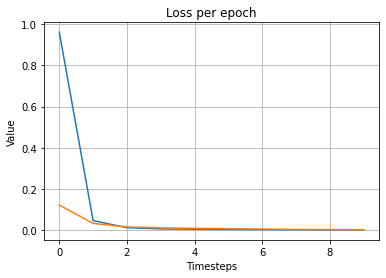

In [73]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_series(range(len(loss)), loss, title='Loss per epoch', xlabel='epoch', ylabel='loss')
plot_series(range(len(val_loss)), val_loss, title='Loss per epoch')

#### Evaluation

In [74]:
model = keras.models.load_model("singlevariate_singlestep.h5")

In [75]:
model.evaluate(x=X_test, y=y_test)

32/32 [==============================] - 1s 12ms/step - loss: 0.0038 - mae: 0.0615


[0.0038391840644180775, 0.06151657924056053]

In [76]:
rnn_forecast = model.predict(X_test)
rnn_forecast.shape

32/32 [==============================] - 1s 15ms/step


(1002, 1)

In [77]:
rnn_forecast = rnn_forecast.reshape(-1)
rnn_forecast.shape

(1002,)

In [78]:
test_series_plt = test_series[n_steps_in:]
test_series_plt.shape

(1002,)

In [79]:
rnn_forecast_plt = rnn_forecast[:-1]
test_series_plt = test_series_plt[1:]
print(rnn_forecast_plt.shape)
print(test_series_plt.shape)

(1001,)
(1001,)


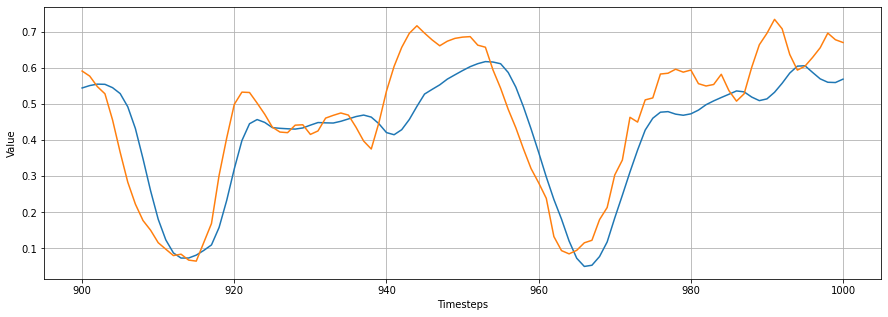

In [80]:
plt.figure(figsize=(15, 5))
time = range(len(rnn_forecast_plt))
plot_series(time, rnn_forecast_plt, format='-', start = 900)
plot_series(time,test_series_plt, format='-', start = 900)

In [81]:
bench_series = create_benchmark_forecast(test_series, n_steps_in, n_steps_out)
benchseries_plt=bench_series.reshape(-1,1)
benchseries_plt.shape

(1002, 1)

In [82]:
test_series_plt = test_series[30:].reshape(-1,1)
print(test_series_plt.shape)

(1002, 1)


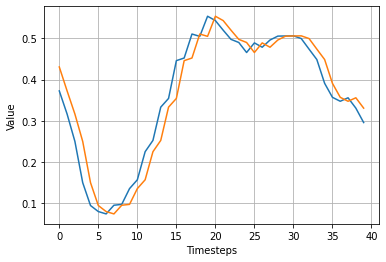

In [83]:
plot_series(range(test_series_plt.shape[0]), test_series_plt, format='-', end=40)
plot_series(range(bench_series.shape[0]), benchseries_plt, format='-', end=40)

In [84]:
keras.metrics.mean_absolute_error(test_series_plt.reshape(1,-1), benchseries_plt.reshape(1,-1)).numpy()

array([0.03197012])

### Multi Step Forecasting using stacked LSTM

#### Data Preparation

In [58]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 2*48, 48
n_features =1
if len(valid_series.shape) > 1:
  n_features==valid_series.shape[1]
# split into samples
# split into samples
X_train, y_train  = create_windowed_datasets(train_series, n_steps_in, n_steps_out)
X_valid, y_valid  = create_windowed_datasets(valid_series, n_steps_in, n_steps_out)
X_test, y_test    = create_windowed_datasets(test_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)
print('X_valid: ', X_test.shape)
print('y_valid: ', y_test.shape)

X_train:  (8113, 96)
y_train:  (8113, 48)
X_valid:  (889, 96)
y_valid:  (889, 48)
X_valid:  (889, 96)
y_valid:  (889, 48)


#### Building and Training of the Model

In [59]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_valid = X_valid.reshape((X_valid.shape[0], X_valid.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(None, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(n_steps_out))
model.add(keras.layers.Lambda(lambda x: x * 200.0))
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=[metric])

model_checkpoint = keras.callbacks.ModelCheckpoint('univariate_multistep.h5')
history = model.fit(x=X_train,
                    y=y_train, 
                    epochs=taxi_epochs,
                    batch_size=32,
                    shuffle = True,
                    callbacks=[reset_states, model_checkpoint, early_stoppage],
                    validation_data=(X_valid, y_valid))

254/254 [==============================] - 32s 115ms/step - loss: 0.0365 - mae: 0.1808 - val_loss: 0.0123 - val_mae: 0.1237


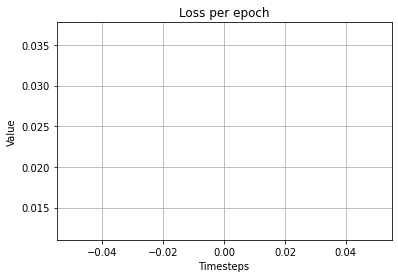

In [60]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_series(range(len(loss)), loss, title='Loss per epoch', xlabel='epoch', ylabel='loss')
plot_series(range(len(val_loss)), val_loss, title='Loss per epoch')

#### Evaluation

In [61]:
model = keras.models.load_model("univariate_multistep.h5")

In [62]:
model.evaluate(x=X_test, y=y_test)

28/28 [==============================] - 1s 31ms/step - loss: 0.0164 - mae: 0.1472


[0.016402829438447952, 0.14720097184181213]

In [63]:
rnn_forecast = model.predict(X_test)
print(rnn_forecast.shape)


28/28 [==============================] - 2s 40ms/step
(889, 48)


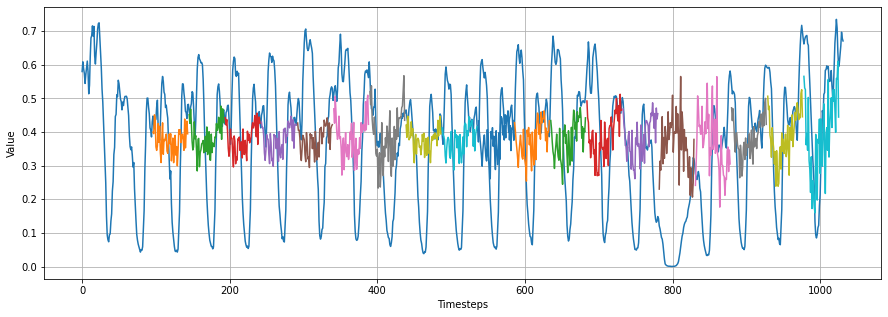

In [64]:
fig = plt.figure(figsize=(15,5))
time = range(test_series.shape[0])
plot_series(time, test_series)

for index in range(0,rnn_forecast.shape[0],49):
  plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), rnn_forecast[index])

## Multivariate Time Series

### Preprocessing Data

In [65]:
df = pd.read_csv('wind.csv')

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


In [67]:
df[df['IND'] == 0].head(5)

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


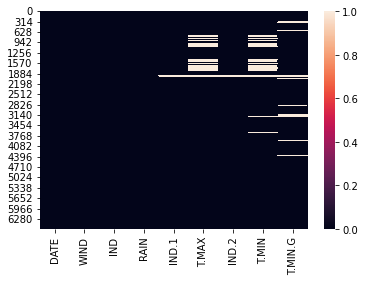

In [68]:
sb.heatmap(df.isnull())

We wil fill all NaN cells with the previous value, since we assume, that wheather only changes slowly.

In [69]:
df = df.fillna(method='ffill');

Since all dates are adjacent, we can drop date column. Also we change datatype of column IND.1 to float 64

In [70]:
df = df.drop(labels=['DATE'], axis=1)

In [71]:
df['IND'] = df['IND'].astype('float64')

Finally put the wind speed column at the last positio and normalize each column with its maximum absolute value.

In [72]:
columns_titles = ['IND', 'RAIN', 'IND.1','T.MAX', 'IND.2', 'T.MIN', 'T.MIN.G', 'WIND']
df=df.reindex(columns=columns_titles)

In [73]:
import math
train_percentage = 0.8
series = df.to_numpy()
#Split in train, validate and test data
train_series, valid_series, test_series, train_split, valid_split = split_series(series, 0.8, 0.1, 0.1)
print('Train data shape: ', train_series.shape)
print('Validation data shape: ', valid_series.shape)
print('Test data shape: ', test_series.shape)

Train data shape:  (5260, 8)
Validation data shape:  (657, 8)
Test data shape:  (657, 8)


### Single Time Step Forecasting using stacked LSTM

#### Data Preparation

In [74]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 10, 1
if len(valid_series.shape) > 1:
  n_features==valid_series.shape[1]
# split into samples
X_train, y_train  = create_windowed_datasets(train_series, n_steps_in, n_steps_out)
X_valid, y_valid  = create_windowed_datasets(valid_series, n_steps_in, n_steps_out)
X_test, y_test    = create_windowed_datasets(test_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)
print('X_test: ', X_test.shape)
print('y_test: ', y_test.shape)

X_train:  (5250, 10, 8)
y_train:  (5250, 1)
X_valid:  (647, 10, 8)
y_valid:  (647, 1)
X_test:  (647, 10, 8)
y_test:  (647, 1)


#### Building and Training of the Model

In [75]:
n_steps_in = X_train.shape[1]
n_features = X_train.shape[2]
n_steps_out= y_train.shape[1]

# define model
model = keras.Sequential()
model.add(keras.layers.LSTM(10, activation='relu', return_sequences=True, input_shape=(None, n_features)))
model.add(keras.layers.LSTM(10, activation='relu'))
model.add(keras.layers.Dense(n_steps_out))
model.add(keras.layers.Lambda(lambda x: x * 200.0))
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=[metric])

model_checkpoint = keras.callbacks.ModelCheckpoint('multivariate_singlestep.h5', save_best_only=True)

# fit model
history = model.fit(x = X_train, 
                    y = y_train,
                    epochs=wind_epochs,
                    shuffle=True,
                    batch_size=32,
                    callbacks = [model_checkpoint, reset_states, early_stoppage],
                    validation_data=(X_valid, y_valid))

Epoch 1/10
165/165 [==============================] - 5s 15ms/step - loss: 53.1162 - mae: 53.6076 - val_loss: 5.8283 - val_mae: 6.3051
Epoch 2/10
165/165 [==============================] - 2s 12ms/step - loss: 4.1944 - mae: 4.6696 - val_loss: 3.2294 - val_mae: 3.7048
Epoch 3/10
165/165 [==============================] - 2s 13ms/step - loss: 3.3810 - mae: 3.8518 - val_loss: 2.8583 - val_mae: 3.3273
Epoch 4/10
165/165 [==============================] - 3s 19ms/step - loss: 3.2235 - mae: 3.6947 - val_loss: 2.7951 - val_mae: 3.2598
Epoch 5/10
165/165 [==============================] - 2s 12ms/step - loss: 3.0923 - mae: 3.5612 - val_loss: 2.7725 - val_mae: 3.2422
Epoch 6/10
165/165 [==============================] - 2s 12ms/step - loss: 3.1259 - mae: 3.5948 - val_loss: 2.7525 - val_mae: 3.2229
Epoch 7/10
165/165 [==============================] - 2s 12ms/step - loss: 3.0213 - mae: 3.4903 - val_loss: 2.7263 - val_mae: 3.1925
Epoch 8/10
165/165 [==============================] - 2s 12ms/step 

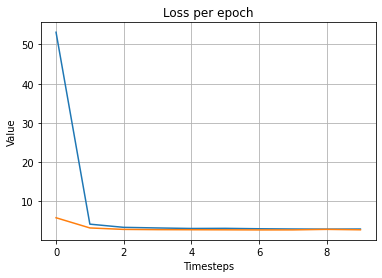

In [76]:
loss = history.history['loss']
val_loss = history.history['val_loss']
plot_series(range(len(loss)), loss, title='Loss per epoch', xlabel='epoch', ylabel='loss')
plot_series(range(len(val_loss)), val_loss, title='Loss per epoch')

#### Evaluation

In [77]:
model = keras.models.load_model('multivariate_singlestep.h5')

In [78]:
model.evaluate(x=X_test, y=y_test)

21/21 [==============================] - 0s 4ms/step - loss: 3.0346 - mae: 3.5056


[3.034597635269165, 3.5055930614471436]

In [79]:
rnn_forecast = model.predict(X_test)
rnn_forecast.shape

21/21 [==============================] - 0s 4ms/step


(647, 1)

In [80]:
rnn_forecast = rnn_forecast.reshape(-1)
rnn_forecast.shape

(647,)

In [81]:
test_series_plt = test_series[n_steps_in:,-1]
test_series_plt.shape

(647,)

In [82]:
rnn_forecast_plt = rnn_forecast[:-1]
test_series_plt = test_series_plt[1:]
print(rnn_forecast_plt.shape)
print(test_series_plt.shape)

(646,)
(646,)


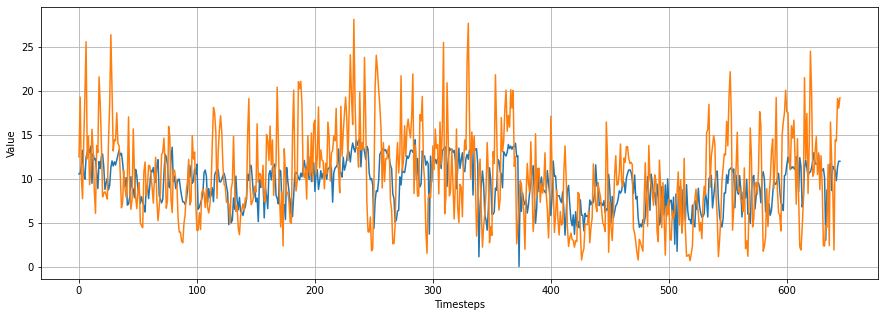

In [83]:
plt.figure(figsize=(15, 5))
time = range(len(rnn_forecast_plt))
plot_series(time, rnn_forecast_plt, format='-', start = 0)
plot_series(time,test_series_plt, format='-', start = 0)

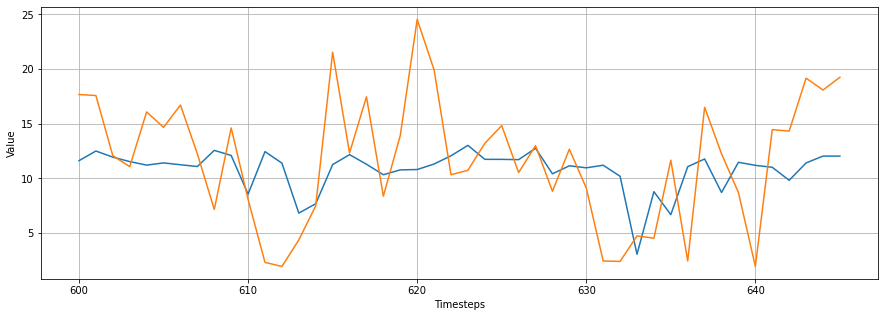

In [84]:
plt.figure(figsize=(15, 5))
time = range(len(rnn_forecast_plt))
plot_series(time, rnn_forecast_plt, format='-', start = 600)
plot_series(time,test_series_plt, format='-', start = 600)

### Multi Step Forecasting

#### Data Preparation

In [85]:
keras.backend.clear_session()
# choose a number of time steps
n_steps_in, n_steps_out = 10, 3
n_features =1
if len(valid_series.shape) > 1:
  n_features==valid_series.shape[1]
# split into samples
# split into samples
X_train, y_train  = create_windowed_datasets(train_series, n_steps_in, n_steps_out)
X_valid, y_valid  = create_windowed_datasets(valid_series, n_steps_in, n_steps_out)
X_test, y_test    = create_windowed_datasets(test_series, n_steps_in, n_steps_out)
print('X_train: ', X_train.shape)
print('y_train: ', y_train.shape)
print('X_valid: ', X_valid.shape)
print('y_valid: ', y_valid.shape)
print('X_valid: ', X_test.shape)
print('y_valid: ', y_test.shape)

X_train:  (5248, 10, 8)
y_train:  (5248, 3)
X_valid:  (645, 10, 8)
y_valid:  (645, 3)
X_valid:  (645, 10, 8)
y_valid:  (645, 3)


#### Building and Training of the Model

In [86]:
n_steps_in = X_train.shape[1]
n_features = X_train.shape[2]
n_steps_out= y_train.shape[1]

# define model
model = keras.Sequential()
model.add(keras.layers.LSTM(10, activation='relu', return_sequences=True, input_shape=(None, n_features)))
model.add(keras.layers.LSTM(10, activation='relu'))
model.add(keras.layers.Dense(n_steps_out))
model.add(keras.layers.Lambda(lambda x: x * 200.0))
model.compile(loss=keras.losses.Huber(),
              optimizer='adam',
              metrics=[metric])

model_checkpoint = keras.callbacks.ModelCheckpoint('multivariate_multistep.h5', save_best_only=True)

# fit model
history = model.fit(x = X_train, 
                    y = y_train,
                    epochs=wind_epochs,
                    shuffle=True,
                    batch_size=32,
                    callbacks = [model_checkpoint, reset_states, early_stoppage],
                    validation_data=(X_valid, y_valid))

Epoch 1/10
164/164 [==============================] - 8s 16ms/step - loss: 26.3502 - mae: 26.8385 - val_loss: 5.5739 - val_mae: 6.0544
Epoch 2/10
164/164 [==============================] - 2s 11ms/step - loss: 4.7806 - mae: 5.2584 - val_loss: 3.5919 - val_mae: 4.0673
Epoch 3/10
164/164 [==============================] - 2s 9ms/step - loss: 3.6328 - mae: 4.1076 - val_loss: 3.0686 - val_mae: 3.5398
Epoch 4/10
164/164 [==============================] - 2s 14ms/step - loss: 3.4121 - mae: 3.8848 - val_loss: 2.9359 - val_mae: 3.4043
Epoch 5/10
164/164 [==============================] - 3s 20ms/step - loss: 3.3460 - mae: 3.8181 - val_loss: 2.8895 - val_mae: 3.3607
Epoch 6/10
164/164 [==============================] - 5s 33ms/step - loss: 3.2978 - mae: 3.7698 - val_loss: 2.8746 - val_mae: 3.3458
Epoch 7/10
164/164 [==============================] - 4s 22ms/step - loss: 3.2661 - mae: 3.7390 - val_loss: 2.8468 - val_mae: 3.3196
Epoch 8/10
164/164 [==============================] - 3s 18ms/step -

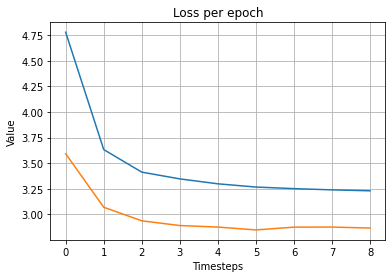

In [87]:
loss = history.history['loss'][1:]
val_loss = history.history['val_loss'][1:]
plot_series(range(len(loss)), loss, title='Loss per epoch', xlabel='epoch', ylabel='loss')
plot_series(range(len(val_loss)), val_loss, title='Loss per epoch')

#### Evaluation

In [88]:
model = keras.models.load_model("multivariate_multistep.h5")

In [89]:
model.evaluate(x=X_test, y=y_test)

21/21 [==============================] - 1s 7ms/step - loss: 3.5062 - mae: 3.9780


[3.5061988830566406, 3.9780068397521973]

In [90]:
rnn_forecast = model.predict(X_valid)
print(rnn_forecast.shape)


21/21 [==============================] - 1s 6ms/step
(645, 3)


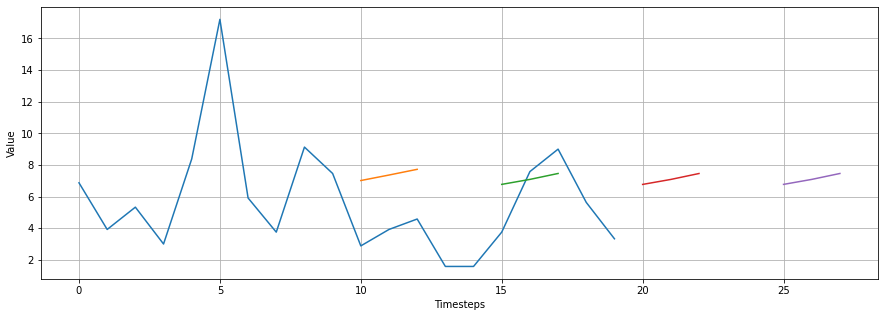

In [91]:
fig = plt.figure(figsize=(15,5))
end = 20
plot_series(range(len(valid_series))[0:end], valid_series[0:end,-1])

for index in range(0,end,5):
  plot_series(range(index + n_steps_in,index + n_steps_in + n_steps_out), rnn_forecast[index])
  plt.grid(visible=True, axis='both')

#### Thoughts for paper

Taxi:
*Steps in in multi step because 98 is exacty 2 days => know , when weekend is

Wind:
* Wind difficult to predict, very volatil, complex wheather models are necessary, got not enaugh data
* Wind dataset: no pattern, so use less units in LSTM, compare it with taxi dataset units
* not good, because no short patterns are availabe. Evtl year to year pattern exists, but for detecting those.

Discussion:
*

Ausblick:
*Andere Architekturen: ConvLSTM-net
*Reine Conve nets
